In [1]:
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import seaborn as sns

from src.results.experiments import _DateExperimentLoader
from src.plot import orig_vs_transformed as plot_ovt
from src.data_loader import Shifted_Data_Loader

Using TensorFlow backend.


In [2]:

lg = _DateExperimentLoader('2019-06-04')
lg.load_configs()
configs = pd.DataFrame.from_records(lg.configs)
configs.head()

# lg_ff.load()

,batch_size,bg_noise,dataset,dec_blocks,ecc_max,enc_arch,enc_blocks,enc_layers,epochs,label_corruption,...,project,recon,rot_max,run_dir,seed,uploaded_by,xcov,xent,y_dim,z_dim
0,512,0.30,fashion_mnist,"[4, 2, 1]",0.6,feedforward,NaN,"[3000, 2000, 500]",10,0.0,...,vae,0,0,/home/elijahc/projects/vae/logs/0729_101426_fa...,7,elijahc,0,15,35,35
1,512,0.10,fashion_mnist,"[4, 2, 1]",0.6,feedforward,NaN,"[3000, 2000, 500]",10,0.0,...,vae,0,0,/home/elijahc/projects/vae/logs/0701_145924_fa...,7,elijahc,0,15,35,35
2,512,0.05,fashion_mnist,"[4, 2, 1]",0.6,feedforward,NaN,"[3000, 2000, 500]",90,0.0,...,vae,0,0,/home/elijahc/projects/vae/logs/0701_145223_fa...,7,elijahc,0,15,35,35
3,512,0.60,fashion_mnist,"[4, 2, 1]",0.6,feedforward,NaN,"[3000, 2000, 500]",10,0.0,...,vae,0,0,/home/elijahc/projects/vae/logs/0702_093030_fa...,7,elijahc,0,15,35,35
4,512,0.00,fashion_mnist,"[4, 2, 1]",0.6,feedforward,NaN,"[3000, 2000, 500]",90,0.0,...,vae,0,0,/home/elijahc/projects/vae/logs/0701_112033_fa...,7,elijahc,0,15,35,35


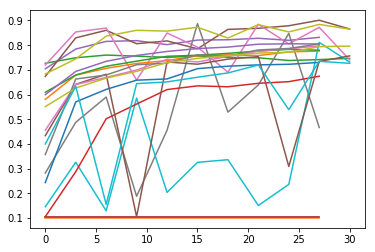

In [3]:
history = lg.load_history()
# history = pd.concat(history)
for c,hist in zip(lg.configs,lg.history):
    plt.plot(hist.epoch,hist.val_class_acc)
# sns.lineplot(x='epoch',y='val_class_acc',hue='architecture',data=history)

In [4]:
hist_df = pd.concat(history)

In [5]:
filt = [v in [0.0,0.05] for v in hist_df.bg_noise.values]

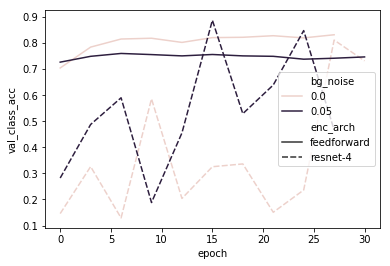

In [6]:
sns.lineplot(x='epoch',y='val_class_acc',
             hue='bg_noise',
             style='enc_arch',data=hist_df[filt].query('recon == 0'),legend='full')

In [7]:
hist_max = hist_df.groupby(['enc_arch','objective_type','bg_noise']).max().reset_index()

In [8]:
DL = Shifted_Data_Loader('fashion_mnist',
                         rotation=None,
                         translation=0.6,
                         flatten=False,
                         seed=7,
                         bg_noise=0.6,
                         bg_only=True,
                        )

input_shape:  (56, 56, 1)
dataset:  fashion_mnist
scale:  2
tx_max:  0.6
rot_max:  None
contrast_level:  1
noise_mode:  None


train images:   0%|          | 0/60000 [00:00<?, ?it/s]

sx_train:  (60000, 56, 56, 1)
transforming: 


test_images:  35%|███▌      | 3528/10000 [00:00<00:00, 35279.87it/s]

making testing data...


test_images: 100%|██████████| 10000/10000 [00:00<00:00, 35442.83it/s]


In [9]:
def plot_noise_grad(DL,levels=[0.0,0.05,0.1,0.3,0.6],cmap='gray',clean=True):
    all_levels = []

    for l in levels:
        sxt_fg = DL.fg_test.copy()
        if l > 0.0:
#             bg_noises.append(DL.bg_test)
            noise = DL.gen_uniform_noise(np.zeros_like(sxt_fg),width=l)
            DL.add_noise(sxt_fg,noise,bg_only=True)

        all_levels.append(np.squeeze(sxt_fg))
    
    rand_idx = np.random.randint(1000)
    fig,axs = plt.subplots(1,len(levels),figsize=(3*len(levels),3))
    for imgs,ax in zip(all_levels,axs):
        ax.imshow(np.squeeze(imgs[rand_idx]),cmap=cmap)
    
    if clean:
        for ax in np.ravel(axs):
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
#             axs[1].get_xaxis().set_visible(False)
#             axs[1].get_yaxis().set_visible(False)
        plt.tight_layout()
    
    return all_levels

In [10]:
# all_bg = plot_noise_grad(DL)

In [26]:
sns.set_context('paper')

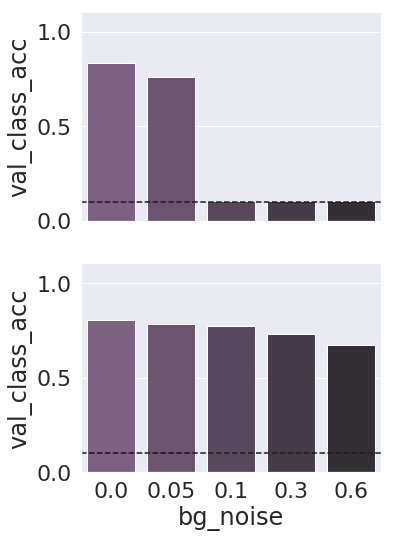

In [54]:
# sns.set_context('talk')
sns.set(font_scale=2)
# bg_noise = [0,0.05,0.1,0.6]
fig,axs = plt.subplots(2,1,figsize=(6,8),sharey=True,sharex=True,subplot_kw={'ylim':(0,1.1),'xlim':(0,1.5)})

for obj,ax in zip(['only_xent','both'],axs):
#     for ax,bg_n,i in zip(ax_row,bg_noise,np.arange(len(bg_noise))):
#     sns.barplot(x='objective_type',y='val_class_acc',data=hist_max.query('bg_noise == {} & enc_arch == "feedforward"'.format(bg_n)),ax=ax)
#     ax.set_title('{}'.format(obj))
    ax.set_ylabel('')
    ax.hlines(0.1,-0.5,6,linestyles='dashed',label='chance')
    sns.barplot(x='bg_noise',y='val_class_acc',data=hist_max.query('enc_arch == "feedforward" & objective_type == "{}"'.format(obj)),ax=ax,
                palette=sns.dark_palette("muted purple", input="xkcd",reverse=True))
    sns.despine(ax=ax)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#     if i < 3:
#         pass
axs[0].get_xaxis().set_visible(False)
        
        
plt.tight_layout()

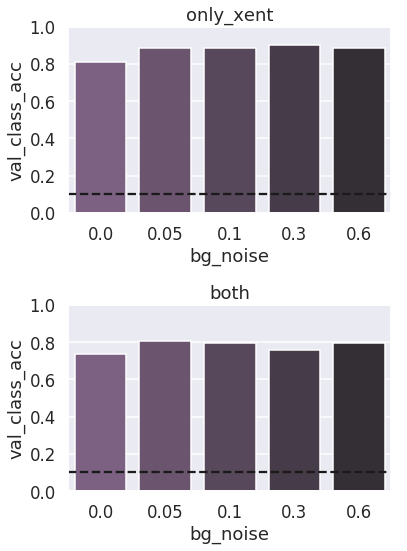

In [38]:
sns.set_context('talk')
# bg_noise = [0,0.05,0.1,0.6]
fig,axs = plt.subplots(2,1,figsize=(6,2*4),sharey=True,subplot_kw={'ylim':(0,1),'xlim':(0,1.5)})

for obj,ax in zip(['only_xent','both'],axs):
#     for ax,bg_n,i in zip(ax_row,bg_noise,np.arange(len(bg_noise))):
#     sns.barplot(x='objective_type',y='val_class_acc',data=hist_max.query('bg_noise == {} & enc_arch == "feedforward"'.format(bg_n)),ax=ax)
    ax.set_title('{}'.format(obj))
    ax.set_ylabel('')
    ax.hlines(0.1,-0.5,6,linestyles='dashed',label='chance')
    sns.barplot(x='bg_noise',y='val_class_acc',data=hist_max.query('enc_arch == "resnet-4" & objective_type == "{}"'.format(obj)),ax=ax,
                palette=sns.dark_palette("muted purple", input="xkcd",reverse=True))
    
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#     if i < 3:
#         pass
# #         ax.get_xaxis().set_visible(False)
        
        
plt.tight_layout()

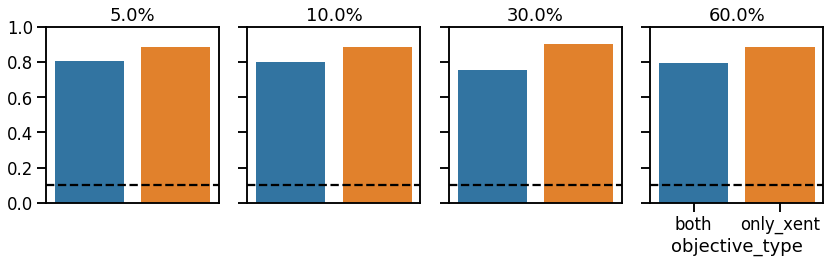

In [13]:
sns.set_context('talk')
fig,axs = plt.subplots(1,4,figsize=(4*3,4),sharex=True,sharey=True,subplot_kw={'ylim':(0,1),'xlim':(0,1.5)})
bg_noise = [0.05,0.1,0.3,0.6]
for ax,bg_n,i in zip(axs,bg_noise,np.arange(4)):
    sns.barplot(x='objective_type',y='val_class_acc',data=hist_max.query('bg_noise == {} & enc_arch == "resnet-4"'.format(bg_n)),ax=ax)
    if i < 3:
        ax.get_xaxis().set_visible(False)
    ax.set_title('{}%'.format(bg_n*100))
    ax.set_ylabel('')
    ax.hlines(0.1,-0.5,1.5,linestyles='dashed',label='chance')
        
plt.tight_layout()

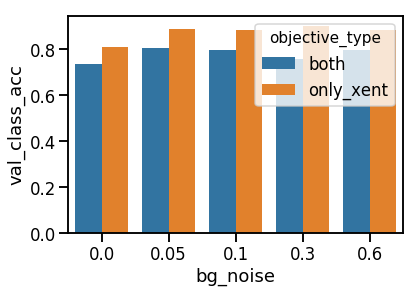

In [14]:
sns.barplot(x='bg_noise',y='val_class_acc',hue='objective_type',data=hist_max.query('enc_arch == "resnet-4"'))

In [15]:
def arch_train_plot():
    fig,axs = plt.subplots(2,1,sharex=True,sharey=True)

    filts = [
        "enc_arch == 'feedforward' & objective_type == '{}'".format('both'),
        "enc_arch == 'feedforward' & objective_type == '{}'".format('only_xent'),
#         "enc_arch == 'resnet-4' & bg_noise == {}".format(bg_noise),
    ]

    for filt,ax in zip(filts,axs):
        df = hist_df.query(filt)
        sns.lineplot(x='epoch',y='val_class_acc',hue='bg_noise',data=df,ax=ax,legend='full')

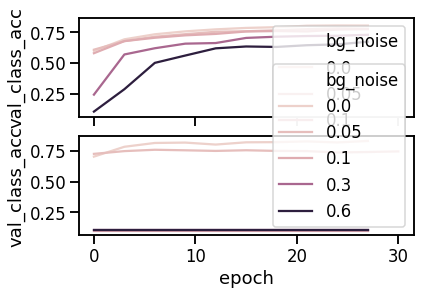

In [16]:
arch_train_plot()

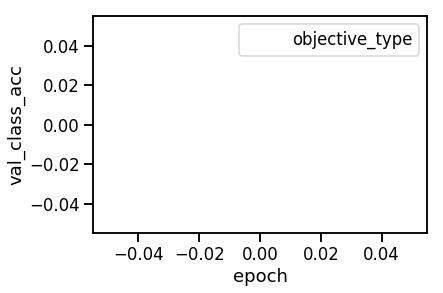

In [17]:
sns.lineplot(x='epoch',y='val_class_acc',hue='objective_type',data=hist_df.query("enc_arch == 'resnet-4' & bg_noise == 0.25"))

In [18]:
configs.groupby(['enc_arch','bg_noise']).count()

batch_size  dataset  dec_blocks  ecc_max  enc_blocks  \
enc_arch    bg_noise                                                         
feedforward 0.00               2        2           2        2           0   
            0.05               2        2           2        2           0   
            0.10               2        2           2        2           0   
            0.30               2        2           2        2           0   
            0.60               2        2           2        2           0   
resnet-4    0.00               2        2           2        2           2   
            0.05               2        2           2        2           2   
            0.10               2        2           2        2           2   
            0.30               2        2           2        2           2   
            0.60               2        2           2        2           2   

                      enc_layers  epochs  label_corruption  last_updated  \
enc_arch    bg_noise                                                       
feedforward 0.00               2       2                 2             2   
            0.05               2       2                 2             2   
            0.10               2       2                 2             2   
            0.30               2       2                 2             2   
            0.60               2       2                 2             2   
resnet-4    0.00               2       2                 2             2   
            0.05               2       2                 2             2   
            0.10               2       2                 2             2   
            0.30               2       2                 2             2   
            0.60               2       2                 2             2   

                      model_dir  ...  project  recon  rot_max  run_dir  seed  \
enc_arch    bg_noise             ...                                           
feedforward 0.00              2  ...        2      2        2        2     2   
            0.05              2  ...        2      2        2        2     2   
            0.10              2  ...        2      2        2        2     2   
            0.30              2  ...        2      2        2        2     2   
            0.60              2  ...        2      2        2        2     2   
resnet-4    0.00              2  ...        2      2        2        2     2   
            0.05              2  ...        2      2        2        2     2   
            0.10              2  ...        2      2        2        2     2   
            0.30              2  ...        2      2        2        2     2   
            0.60              2  ...        2      2        2        2     2   

                      uploaded_by  xcov  xent  y_dim  z_dim  
enc_arch    bg_noise                                         
feedforward 0.00                2     2     2      2      2  
            0.05                2     2     2      2      2  
            0.10                2     2     2      2      2  
            0.30                2     2     2      2      2  
            0.60                2     2     2      2      2  
resnet-4    0.00                2     2     2      2      2  
            0.05                2     2     2      2      2  
            0.10                2     2     2      2      2  
            0.30                2     2     2      2      2  
            0.60                2     2     2      2      2  

[10 rows x 23 columns]